#### 11/2/20

# Quick Start Guide 
-----------------
This notebook will show how to run a basic experiment using the `cfl` package. It will also explain the visual bars data and some background for CFL. 



Contents 
- Background: What is CFL?
- Importing the `cfl` package 
- Background: Visual Bars Data 
- Loading Data 
- Saving Results 
- Training and Predicting with a CFL object 
- Visualizing the results  
- Beyond the Basics: Training and predicting just the conditional density or just with clustering 
- Beyond the Basics: Loading Saved Weights


## Background 

Macrovariables are a useful way to summarize the relevant features detailed, low-level data at a higher level. For example, instead of keeping track of the kinetic energy of every particle in a room, we can instead monitor just the temperature of the room. In this case, 'temperature' is a macrovariable which summarizes the kinetic energy in the room. Additionally, all the particle configurations which have the same temperature (i.e. are part of the same macrovariable class) may differ in some ways, but for many purposes, are functionally the same. Thus, macrovariables can abstract away unnecessary information while preserving important distinctions. Which features are important to distinguish depends on the task for which the macrovariable is being used. 

Causal Feature Learning (CFL) is an algorithm designed to construct macrovariables from low-level data in an unsupervised manner while accounting for the causal relationships between these macrovariables. CFL is designed to take two data sets as input. The `X` dataset contains all of the features which may potentially cause the effects seen in the `Y` dataset. The word "potentially" is used because both datasets may contain features which turn out not to be causally relevant; if that is the case, then CFL should not consider them when assigning a macrovariable label. CFL partitions each input dataset into a set of macrovariables: `X` into a set of macro-causes (e.g. the temperature of the room) and `Y` into a set of macro-effects (e.g. whether someone turns on the air conditioner). 

CFL works by first learning the conditional probability distribution $P(Y|X)$ (or some reasonable proxy for this distibution). This step is called conditional density estimation, or CDE. It then clusters together `X`s for which the equivalence relation $P(Y|X=x_1) = P(Y|X=x_2)$ is (approximately) true, followed by clustering `Y`s for which the relation $P(Y=y_1|X) = P(Y=y_2|X)$ approximately holds. Thus, CFL works in two steps: first, it estimates a conditional probability distribution; and second, it clusters based on that distribution. The image below provides a visual overview of the inputs and outputs of each step of CFL. 

<img src="img/CFLpipeline.png" alt="Overview of CFL pipeline" height="200"/>

As stated above, CFL learns a method to partition the sample space of each dataset. This information is contained in the parameters of the trained model. These parameters generate the labels that are output at the end of training and can be used to classify new data into macrovariables.


In [1]:
#import standard pacakges 
import numpy as np #needed for reshaping arrays 
import matplotlib.pyplot as plt #for rendering plots

## Importing the `cfl` package 

Type `import cfl` in order to import the entire `cfl` package, or import the specific modules you intend to use. 

In [3]:
# importing cfl will import all of the sub-modules inside of cfl as well
import cfl

# you can also import specific files, functions, or classes
# into the local namespace 
from cfl.cfl_wrapper import make_CFL
from cfl.save.experiment_saver import ExperimentSaver
from cfl.dataset import Dataset

# or rename modules for brevity 
from cfl.visualization_methods import visual_bars_vis as vis

## Background: Visual Bars Data

For this experiment, we will use the Visual Bars dataset (from Chalupka 2015). 

The causal dataset consists of a set of binary (black-and-white) images. These images each have a black background 
and contain white pixels of random noise. Each image may also contain either a white vertical and/or a horizontal bar. Below are a few sample images. 

<img src="img/vbImage1.png" alt="Sample Visual Bars Image" height="150"/>
<img src="img/vbImage2.png" alt="Sample Visual Bars Image" height="150"/>
<img src="img/vbImage3.png" alt="Sample Visual Bars Image" height="150"/>


The effect dataset (aka the "target") is, in this case, a single-dimensional, binary variable. In other words, there is only one variable in the target data set, and that variable can either take on the value of "0" or "1". 

The underlying causal structure used to generate the visual bars images is shown below. The solid circles are the observed variables, the dotted lines are hidden (unobserved) variables, and the arrows denote a causal relationship from one variable to another. 


<img src="img/VisualBarsCausal.png" alt="causal graph for visual bars" height="300"/>

The causal graph includes two 'hidden variables' ($H_1$ and $H_2$), whether an image contains a horizontal and/or vertical bar, and the target variable's value. The values of hidden variables are not observed directly in the data, but they impact the values of variables that we do observe. 

More specifically, when the $H_{1}$ hidden variable is "on", that causes a vertical bar to be present in the image. It also increases the probability that the target variable's value will be $1$. The $H_{2}$ hidden variable causes a horizontal bar to be present in the image, but does not directly impact the value of the target. The presence of a horizontal bar in the image increases the probability of the target's value being $1$, but the presence of a vertical bar does not directly impact the value of the target variable. 

Wow! All that's a little confusing. What does it mean? 

Basically, this means that there is confounding in our data! You can see in the image above that $H_{1}$ has influence on both the contents of the images, and on the target directly. Confounding makes disentangling the causal relationships a little more complicated. 


So, for this data set, we want CFL to separate the images into four observational macrovariables: one for each combination of values for $H_1$ and $H_2$. This will allow later researchers to design later experiments that determine which of the differences in these macrovariables are causally important (vs merely predictive).

The table below shows the 'ground truth' probability of the target value being $1$, given each possible state of the hidden variables. These values are used to generate the target values. At the end of the CDE step of CFL, we want to recover these probabilities as accurately as possible, and by the end of the clustering step, recover these four categories.

<img src="img/VisualBarsProbs.png" alt="probability table for visual bars" height="150"/>


## Loading Visual Bars Data

In order to create a visual bars data set (ie a set of images and associated target values), we need to import the file `generate_visual_bars_data.py`. If you are trying to generate the visual bars data from somewhere outside the root directory of the reposity, add the visual_bars_test directory path to the PYTHONPATH (same as you did for the `cfl` package) for easy importing. 

In [4]:
#import the file to generate visual bars data 
import visual_bars.generate_visual_bars_data as vbd

# uncomment this line and use it instead if you have added visual_bars_test to the pythonpath
# import generate_visual_bars_data as vbd

In order to generate visual bars data, we set the number of images we want to generate (`n_samples`), the size of each image in pixels (`im_shape`), and the intensity of random noise in the image (`noise_lvl`). To have reproducible results, we also will set a random seed. 

In [5]:
n_samples = 1000
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180

# create visual bars data 
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)

We save the images from this data to a variable `X` and the array of target behavior to a variable `Y`. Note that `X` and `Y` are aligned - they must have the same number of observations, and the nth image in `X` must correspond to the nth target value in `Y`. 

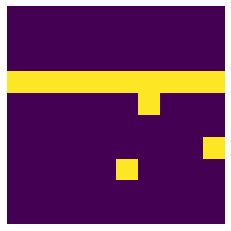

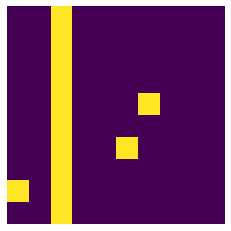

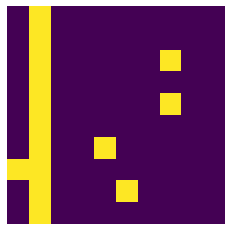

(1000, 10, 10)
(1000,)
True


In [6]:
# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()

# visualize some example images 
vis.viewSingleImage(X)
vis.viewSingleImage(X)
vis.viewSingleImage(X)

# X and Y have the same number of rows  
print(X.shape)
print(Y.shape)
print(X.shape[0]==Y.shape[0])

### Shaping the Data 

Before putting our data into CFL, we must reshape `X` and `Y` into the right shapes to be passed through the conditional density estimation (CDE) step of CFL. Most of the models we use expect data with 2 dimensions, where the first dimension is samples and the second is features. Since `X` is currently 3-dimensional (an array of 2D images), we need to flatten the 2D images into 1-D before passing `X` in. NOTE: not all CDEs need the same input shape! Most take in 1D inputs, but a convolutional neural net (CNN), take in 2D input. If we were using a CNN, we would not flatten `X`. 

We then expand `Y` because it is currently only 1D. Expanding to 2 dimensions makes `Y` have the shape `(n_samples, 1)` instead of `(n_samples,)`.

In [7]:
#reformat x, y into the right shape for the neural net 

# flatten X 
X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2])) 
print(X.shape)

# expand Y
Y = np.expand_dims(Y, -1)
print(Y.shape)

(1000, 100)
(1000, 1)


### Key Points for Loading Data
1. The data should consist of a data set `X` and a data set `Y` that are aligned (each row in `X` corresponds to the row with the same index in `Y`)
2. For most instances of CFL, `X` and `Y` should be reshaped such that that each one is a 2D array, where the first dimension is samples/observations and the second dimension is all the features 

## Saving Results 

We will now set up an `ExperimentSaver`. This will save not only the results from each step of CFL, but also the parameters input to CFL. This is an optional step; if you do not create an `ExperimentSaver`, then the CFL parameters and results will not be saved. 

We will also pass the X and Y data and the `ExperimentSaver` into a `Dataset` object. (This step is necessary; CFL only accepts a `Dataset` object). By associating this dataset with an `ExperimentSaver`, the results from running this dataset through a CFL pipeline will be saved in an appropriate location. Then, every time we pass that `Dataset` through any part of the CFL pipeline, the results will automatically be stored in a directory associated with that `Dataset` and experiment.

We need to create a new `ExperimentSaver` every time we begin a new experiment; that means every time we change the CFL configuration. 
This can happen if either  
1. The CFL parameters change or
2. The data that we train the CFL with changes 

In [8]:
# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
experiment_saver = ExperimentSaver('results/visual_bars')

# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset0'
train_dataset = Dataset(X, Y, dataset_label='train_data', experiment_saver=experiment_saver)

base_path 'results/visual_bars' doesn't exist, creating now.
All results from this run will be saved to results/visual_bars\experiment0000


## Training and Predicting with a CFL object 

Now we're ready to go! 

CFL takes in several sets of parameters, each in dictionary form: 
- `data_info`  
- `CDE_params`   
- `cluster_params`   

For further details on the meaning of these parameters, consult the documentation for the clusterer and the CondExp base class. 

Note that not all of the CDE_params listed here need to be specified - if they are not specified, default values will be provided.  


In [9]:
# set all CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,  #these first four parameters control the training 
               'optimizer'   : 'adam',
               'n_epochs'    : 60,
               'opt_config'  : {'lr': 1e-3}, 
               'verbose'     : 1,  #these last two parameters control what output is displayed
               'show_plot'   : True }

# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 2 }

Then we make the cfl object with the `make_CFL` function! This function allows you to create both parts of the cfl model in one step. It takes in the parameter dictionaries, and strings specifying which type of CDE/ clusterer to use. In this case, we use our basic Conditional Expection model for CDE, and K-means for clustering. Consult the PyDoc documentation for the other available models. Note that we didn't specify some parameters, and so those parameters are given default values and  printed below. 


In [10]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpVB', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) 

dense_units not specified in params, defaulting to [50, 1]
activations not specified in params, defaulting to ['relu', 'linear']
dropouts not specified in params, defaulting to [0, 0]
weights_path not specified in params, defaulting to None
loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExp


TypeError: __init__() got an unexpected keyword argument 'experiment_saver'

We now train the CFL object on our data. 

A progress bar is printed for each epoch of training, and then a graph of the loss over training is displayed. The blue line represents the loss for the training set and the orange line represents the loss for the validation set. When the training and the validation loss converge and flatten out, then the model has been trained for a sufficient number of epochs. 

In [ ]:
train_results = cfl_object.train(train_dataset, standardize=False)

The results come in the form `(x_labels, y_labels, train_loss, test_loss)`. 
The `x_labels` and `y_labels` are the macrovariable labels for each sample in the `X` and `Y` data set, respectively, 
and the train and test losses are the losses from the density estimation step of training. Below, we print the first few `x_lbls`. We can see that, there are 4 classes in the data, and that they are represented by the numbers `0` through `3`. Each of these labels tells us the macrovariable to which the corresponding visual bars image was assigned. 

In [ ]:
print(train_results[0][:20])

To predict on different data using the previously trained model, we just create a second data set with the same experiment_saver, and call the predict method on that new dataset: 

In [ ]:
n_samples = 100
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180 

# make second dataset for prediction
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X_new = vb_data.getImages()
Y_new = vb_data.getTarget()

#reformat x, y into the right shape for the neural net 
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1]*X_new.shape[2])) 
Y_new = np.expand_dims(Y_new, -1)

# put X, Y into a new Dataset object
dataset_new = Dataset(X_new, Y_new, dataset_label='dataset_new', experiment_saver=experiment_saver) 

# predict! 
results_new = cfl_object.predict(dataset_new)

## Visualize Results 
We can view some images with their predicted label using the `viewImages` function. As we can see, the results are pretty inconsistent - multiple images that should be in the same class are part of different classes. This is in part because our sample size is not quite large enough for CFL to learn it very well. Try this experiment again with a larger sample size and see how the results change. You can also try with a different type of density estimator. 

In [ ]:
vis.viewImagesAndLabels(X_new, im_shape=im_shape, n_examples=10, x_lbls=results_new[0])

## Beyond the Basics: Training and predicting with just the conditional density or just with clustering 

In some cases, you may not want to perform both steps of CFL on your data, but rather just one of the steps. In that case, you need to make the CDE or clusterer object individually. 

The commands to train and predict with a component of the CFL follow the same pattern as with the full CFL. Here is a demonstration with a CDE: 

In [ ]:
# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
# note: each new instantiation of ExperimentSaver will create a new experiment000x directory.
# here, we will be runninga new configuration of CFL, so we want to store this in a new experiment
experiment_saver2 = ExperimentSaver('results/visual_bars')

# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset2'
n_samples = 1000
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180 
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)
dataset2 = Dataset(X, Y, dataset_label='dataset2', experiment_saver=experiment_saver2)

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,
               'optimizer'   : 'adam',
               'n_epochs'    : 60,
               'opt_config'  : {'lr': 1e-3},
               'verbose'     : 1,
               'show_plot'   : False }

# construct a CDE object (no saver specified - results will not be saved)
CDE_object = cfl.density_estimation_methods.condExpVB.CondExpVB(data_info, CDE_params, experiment_saver=experiment_saver)

# training a CDE object is very straightforward! 
CDE_object.train(dataset2, standardize=False, best=True)

#predicting with it is also easy! 
CDE_object.predict(dataset2)


The scatter plot below shows the output of the CDE for 1000 samples. The Y-axis shows the expectation of the target given X, which, since the target is a binary variable, is equivalent to the probability that the target equals 1. The colors of the dots indicate which "ground truth" class the sample belongs to. Ideally, this plot would show the same conditional probabilities as in the ground truth table above (in the Visual Bars Background section). However, as evidenced by the mixing between the blue and teal dots, we can see that the CDE did not learn to distinguish very well between the images containing just a horizontal bar or just a vertical bar.

In [ ]:
# create a scatter plot showing conditional expectation of the target, as predicted by the CDE, 
# colored by ground truth class  
truth = vb_data.getGroundTruth()
fig = plt.figure()
plot_idx = np.random.choice(dataset2.pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), dataset2.pyx[plot_idx], c=truth[plot_idx])
plt.xlabel('Samples')
plt.ylabel('Expectation of Y Given X')
fig.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(dataset2.pyx[truth==i])))


The input and output a component needs depends on which step of CFL you're using: 

<img src="img/SampleCFLworkflow.png" alt="sample CFL workflow, showing inputs and outputs of each step" height="200"/>

So if you are working with just the clusterer, you need to input the conditional expectations, not the dataset! Below is an example creating and training using a Kmeans clusterer. 

In [ ]:
#we'll use the same dataset2 from above 

# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 2 }

# create a clusterer object 
clusterer = cfl.cluster_methods.kmeans.KMeans(cluster_params) 

#train 
x_lbls, y_lbls = clusterer.train(dataset2)

## Beyond the Basics: Loading Saved Results 

You can load a previously trained conditional density model by specifying a `weights_path` in the CDE_params dictionary. This can be helpful in the case where we want to tune the clusterer, but don't want to wait for the CDE to train every time we retrain the clusterer. 


Note: in the future, we will implement the ability to load parameters and the clusterer model from previous runs, but those methods doesn't exist at the moment. 

In [ ]:
# making a new experiment to save to, because we're going to train a new clusterer!

# save experiment results from this CFL configuration across all datasets to 'results/visual_bars/experiment000x'
experiment_saver_new = ExperimentSaver('results/visual_bars')

# construct dataset. this will save all dataset-specific results to 'results/visual_bars/experiment000x/dataset0'
# use the same dataset as before, to compare against original clusterer
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver_new) # using new experiment saver

In [ ]:
# set all CFL parameters

# dataset params should be same as before
# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# using same cde architecture as before
# conditional density estimator parameters
CDE_params = { 'batch_size'  : 32,
               'optimizer'   : 'adam',
               'n_epochs'    : 60,
               'opt_config'  : {'lr': 1e-3},
               'verbose'     : 1,
               'show_plot'   : False,
               'weights_path': 'results/visual_bars/experiment0000/train_data/checkpoints/best_weights' } # we want a pretrained cde to skip right to clustering

# we're going to try different cluster parameters!    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 6 }

In [ ]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpVB', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) # new experiment saver

In [ ]:
# this should skip cde training and just go straight to clustering
train_results = cfl_object.train(dataset0, standardize=True)